## Data simulation in scib

Code from https://github.com/theislab/scib-reproducibility/tree/main/notebooks/data_preprocessing/simulations. Simulation were generated using the Splatter package.

In [1]:
proj_name = "simulate_batch_scib"
data_dir = paste0("../data/", proj_name, "/")
dir.create(data_dir)
save_dir = paste0("../save/", proj_name, format(Sys.time(), "%b%d"), "/")
dir.create(save_dir)
seed = 0
set.seed(seed)

Warning message in dir.create(data_dir):
"'../data/simulate_batch_scib' already exists"


In [6]:
library(splatter)
#' Sample group proportions
#'
#' Downsample a Splat simulation to get the desired cell proportions
#'
#' @param sim SingleCellExperiment containing a Splat simulation
#' @param batch_ncells Final number of cells in each batch
#' @param batch_props Final cell proportions in each batch
#'
#' @return Downsampled SingleCellExperiment object
sample_group_props <- function(sim, batch_ncells, batch_props) {

    # Get the cell metadata
    col_data <- as.data.frame(colData(sim))

    # Get the current counts of each group in each batch
    sim_batch_group_count <- table(col_data$Batch, col_data$Group)

    # Get the final number of each group in each batch
    batch_group_ncells <- lapply(seq_along(batch_ncells), function(idx) {
        batch_ncells[idx] * batch_props[[idx]]
    })

    # Check that we aren't trying to get more cells than we have
    lapply(seq_along(batch_group_ncells), function(idx) {
        if (any(batch_group_ncells[[idx]] > sim_batch_group_count[idx, ])) {
            stop("Not enough cells for these proportions in batch ", idx)
        }
    })

    # Downsample cells
    selected <- lapply(seq_along(batch_group_ncells), function(batch) {
        group_cells <- batch_group_ncells[[batch]]
        is_batch <- col_data$Batch == paste0("Batch", batch)
        batch_groups <- col_data$Group[is_batch]
        # Downsample batch
        selected_batch <- sapply(seq_along(group_cells), function(group) {
            is_group <- batch_groups == paste0("Group", group)
            sample(col_data$Cell[is_batch][is_group], group_cells[group])
        })
        unlist(selected_batch)
    })
    selected <- as.character(unlist(selected))

    # Subset SingleCellExperiment
    sim[, selected]
}

In [3]:
base_params <- newSplatParams()

sim2_params <- setParams(
    base_params,
    lib.loc        = 12,
    # Two batches with 1000 cells each. Needs to be more than we want in the
    # final simulation.
    batchCells     = c(1000, 1000, 1000, 1000) * 10,
    batch.facLoc   = c(0.20, 0.25, 0.22, 0.28),
    batch.facScale = c(0.10, 0.08, 0.12, 0.10),
    # Groups with equal probabilities
    group.prob     = rep(1, 4) / 4,
    # Differential expression by group
    de.prob        = c(0.10, 0.12, 0.08, 0.20),
    de.facLoc      = c(0.10, 0.08, 0.12, 0.18),
    de.facScale    = c(0.40, 0.30, 0.45, 0.48),
    # Seed
    seed           = 1
)

sim2_full <- splatSimulateGroups(sim2_params)


Getting parameters...

Creating simulation object...

Simulating library sizes...

Simulating gene means...

Simulating batch effects...

Simulating group DE...

Simulating cell means...

Simulating BCV...

Simulating counts...

Simulating dropout (if needed)...

Sparsifying assays...

Automatically converting to sparse matrices, threshold = 0.95

Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix

Skipping 'BaseCellMeans': estimated sparse size 1.5 * dense matrix

Skipping 'BCV': estimated sparse size 1.5 * dense matrix

Skipping 'CellMeans': estimated sparse size 1.49 * dense matrix

Skipping 'TrueCounts': estimated sparse size 2.13 * dense matrix

Skipping 'counts': estimated sparse size 2.13 * dense matrix

Done!



In [4]:
dim(sim2_full)

[1] 10000 40000

In [5]:
# Number of cells in each batch in the final simulation
batch_ncells <- c(500, 500, 500, 500) * 10
# Proportions in each group in each batch that we want. Should sum to 1.
batch_props <- list(
    c(0.35, 0.22, 0.25, 0.18),
    c(0.25, 0.40, 0.27, 0.10),
    c(0.30, 0.15, 0.35, 0.20),
    c(0.10, 0.30, 0.20, 0.40)
)

In [7]:
# Downsample cells in our simulation
message("Downsampling cells...")
sim2 <- sample_group_props(sim2_full, batch_ncells, batch_props)

Downsampling cells...



In [8]:
dim(sim2)

[1] 10000 20100

In [9]:
batch_count_props <- c(
    Batch1 = 1.00,
    Batch2 = 0.70,
    Batch3 = 0.60,
    Batch4 = 0.30
)

cell_count_props <- batch_count_props[colData(sim2)$Batch]


In [21]:
add_subbatches <- function(sim, subbatch_props) {
    message("Adding subbatches...")

    params <- metadata(sim)$Params
    n_batches <- getParam(params, "nBatches")

    if (!all(sapply(subbatch_props, sum) == 1)) {
        stop("Not all subbatch props sum to 1")
    }

    colData(sim)$SubBatch <- NA

    for (batch_idx in seq_len(n_batches)) {

        message("Processing Batch ", batch_idx, "...")

        batch <- paste0("Batch", batch_idx)
        is_batch <- colData(sim)$Batch == batch
        batch_size <- sum(is_batch)

        subbatches <- BBmisc::chunk(colnames(sim)[is_batch],
                                    props = subbatch_props[[batch_idx]],
                                    shuffle = FALSE)

        for (subbatch_idx in seq_along(subbatches)) {

            message("Adding SubBatch ", subbatch_idx, "...")

            subbatch_cells <- subbatches[[subbatch_idx]]

            noise_sim <- splatSimulate(
                batchCells = length(subbatch_cells),
                lib.loc    = 8.00,
                lib.scale  = 0.50,
                verbose    = FALSE,
                seed       = batch_idx * subbatch_idx
            )
            counts(sim)[, subbatch_cells] <- counts(sim)[, subbatch_cells] + as.matrix(counts(noise_sim))

            
            colData(sim)[subbatch_cells, "Sub"] <- paste0("Sub", subbatch_idx)
            colData(sim)[subbatch_cells, "SubBatch"] <- paste0(batch,
                                                               "Sub", subbatch_idx)
        }
    }

    return(sim)
}


In [22]:
subbatch_props <- list(
    c(0.25, 0.25, 0.25, 0.25),
    c(0.30, 0.30, 0.20, 0.20),
    c(0.40, 0.25, 0.25, 0.10),
    c(0.35, 0.35, 0.15, 0.15)
)

sim2 <- add_subbatches(sim2, subbatch_props)

Adding subbatches...

Processing Batch 1...



Adding SubBatch 1...



[1] 10000  1250
[1] 10000  1250
[1] 10000  1250
[1] 2


Adding SubBatch 2...



[1] 10000  1250
[1] 10000  1250
[1] 10000  1250
[1] 2


Adding SubBatch 3...



[1] 10000  1250
[1] 10000  1250
[1] 10000  1250
[1] 2


Adding SubBatch 4...



[1] 10000  1250
[1] 10000  1250
[1] 10000  1250
[1] 2


Processing Batch 2...

Adding SubBatch 1...



[1] 10000  1530
[1] 10000  1530
[1] 10000  1530
[1] 2


Adding SubBatch 2...



[1] 10000  1530
[1] 10000  1530
[1] 10000  1530
[1] 2


Adding SubBatch 3...



[1] 10000  1020
[1] 10000  1020
[1] 10000  1020
[1] 2


Adding SubBatch 4...



[1] 10000  1020
[1] 10000  1020
[1] 10000  1020
[1] 2


Processing Batch 3...

Adding SubBatch 1...



[1] 10000  2000
[1] 10000  2000
[1] 10000  2000
[1] 2


Adding SubBatch 2...



[1] 10000  1250
[1] 10000  1250
[1] 10000  1250
[1] 2


Adding SubBatch 3...



[1] 10000  1250
[1] 10000  1250
[1] 10000  1250
[1] 2


Adding SubBatch 4...



[1] 10000   500
[1] 10000   500
[1] 10000   500
[1] 2


Processing Batch 4...

Adding SubBatch 1...



[1] 10000  1750
[1] 10000  1750
[1] 10000  1750
[1] 2


Adding SubBatch 2...



[1] 10000  1750
[1] 10000  1750
[1] 10000  1750
[1] 2


Adding SubBatch 3...



[1] 10000   750
[1] 10000   750
[1] 10000   750
[1] 2


Adding SubBatch 4...



[1] 10000   750
[1] 10000   750
[1] 10000   750
[1] 2


In [24]:
message("Downsampling counts...")
counts(sim2) <- DropletUtils::downsampleMatrix(counts(sim2), cell_count_props,
                                               bycol = TRUE)

Downsampling counts...



In [25]:
message("Calculating QC...")
sim2 <- scater::addPerCellQC(sim2)

# Reorder by SubBatch
subbatch_order <- order(colData(sim2)$SubBatch)
sim2 <- sim2[, subbatch_order]

discard <- lapply(unique(colData(sim2)$SubBatch), function(subbatch) {
    in_batch <- colData(sim2)$SubBatch == subbatch
    scater::quickPerCellQC(colData(sim2)[in_batch, ], nmads = 2)$discard
})
discard <- unlist(discard)
colData(sim2)$Discard <- discard

Calculating QC...



In [27]:
table(colData(sim2)$Discard)


FALSE  TRUE 
19318   782 

In [28]:
message("Filtering cells...")
sim2_qc <- sim2[, !discard]
message("Filtering genes...")
sim2_qc <- scater::addPerFeatureQC(sim2_qc)
is_exprs <- rowData(sim2_qc)$detected >= 0.01
sim2_qc <- sim2_qc[is_exprs, ]

Filtering cells...

Filtering genes...



In [29]:
message("Normalising...")
sim2 <- scater::logNormCounts(sim2)
sim2_qc <- scater::logNormCounts(sim2_qc)
message("Embedding...")
sim2 <- scater::runTSNE(sim2)
sim2_qc <- scater::runTSNE(sim2_qc)

Normalising...

Embedding...



Saving QC plots..



Saving 7 x 7 in image


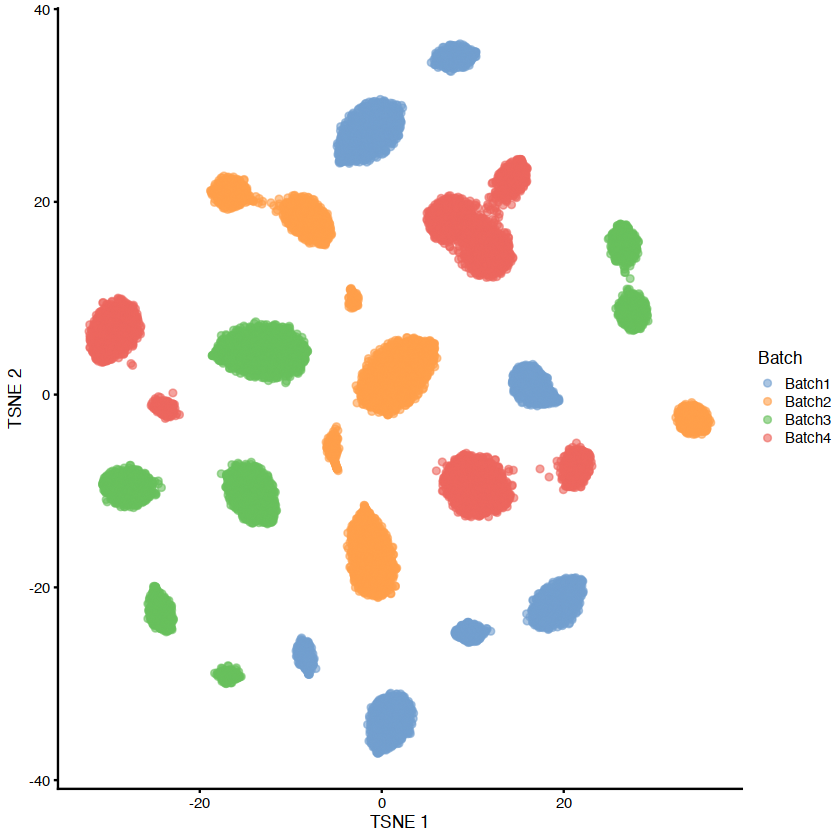

Saving 7 x 7 in image


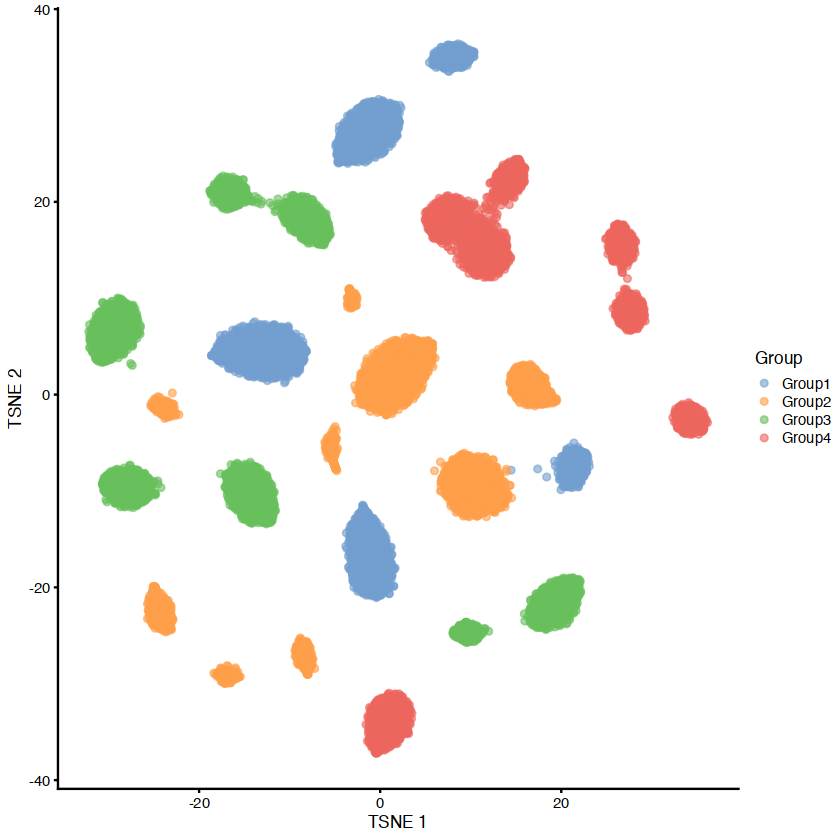

Saving 7 x 7 in image


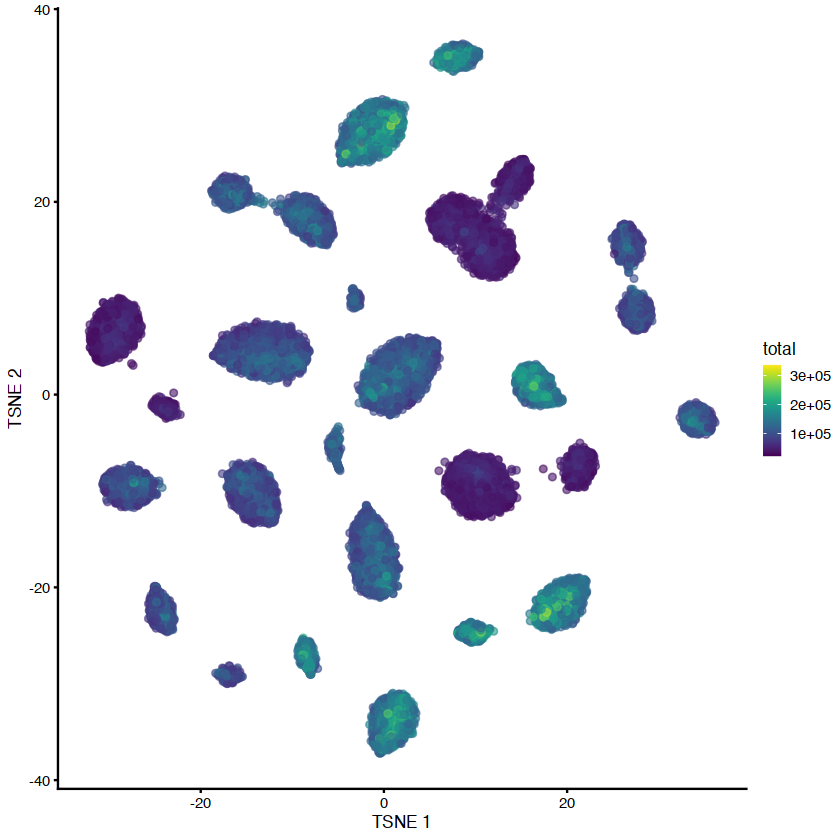

Saving 7 x 7 in image


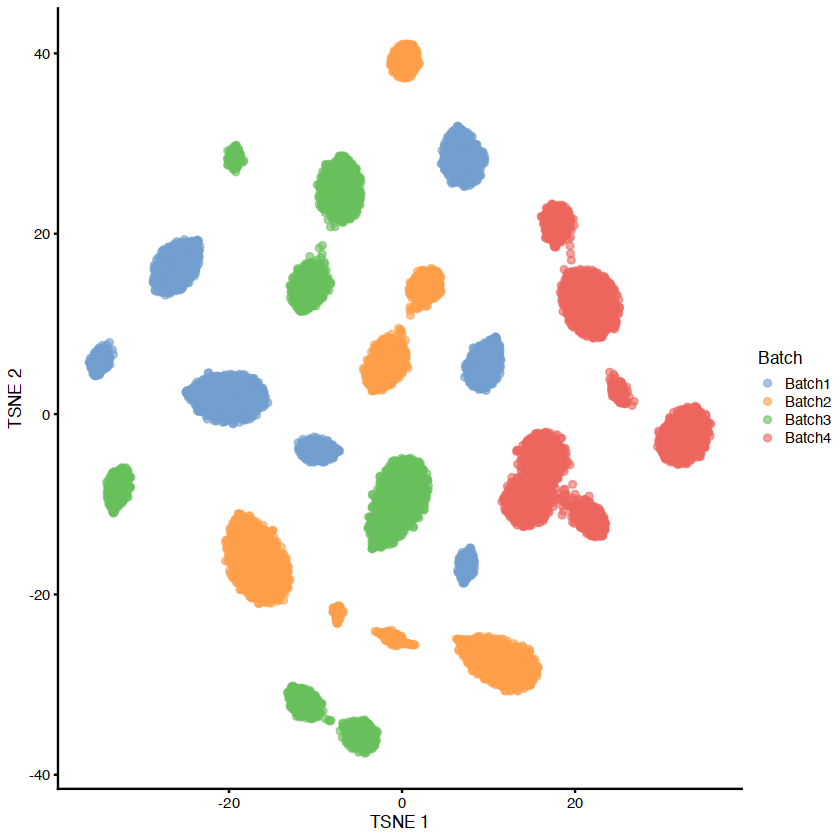

Saving 7 x 7 in image


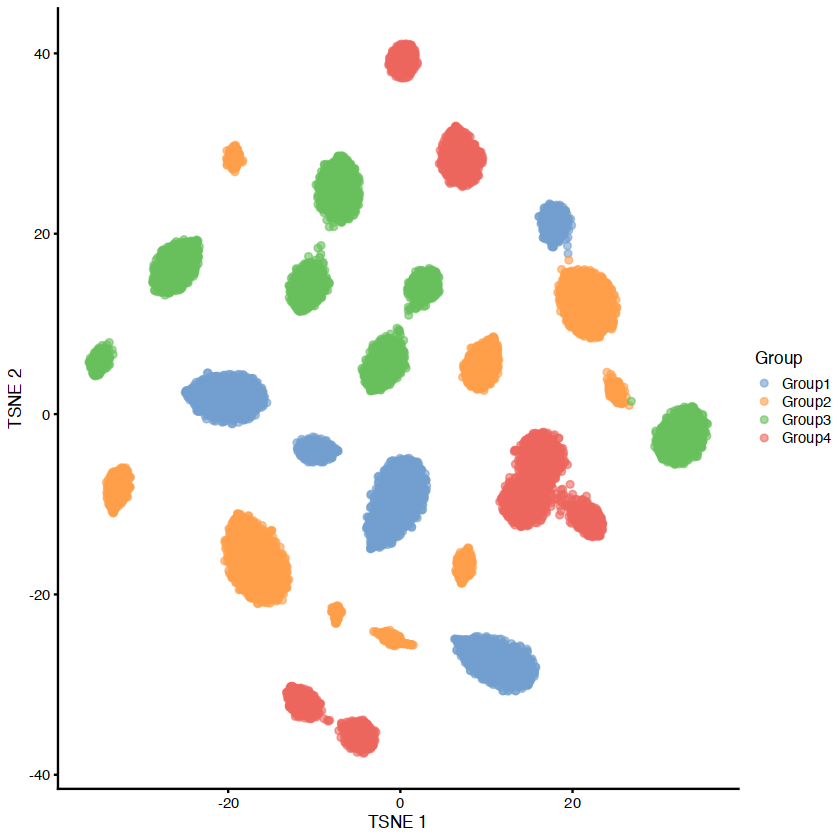

Saving 7 x 7 in image


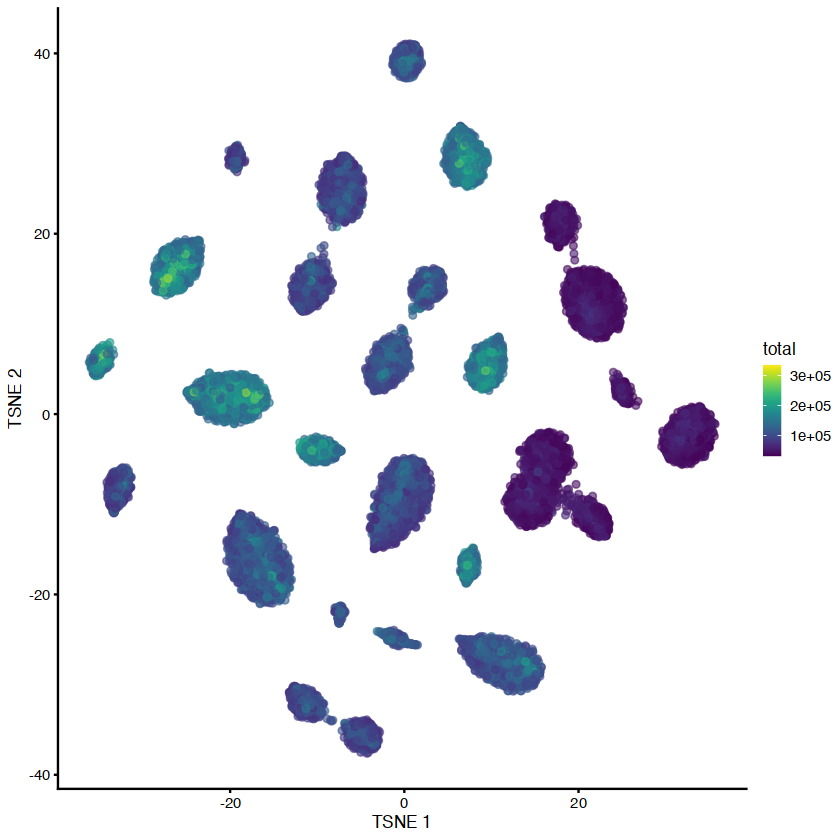

Saving 7 x 7 in image


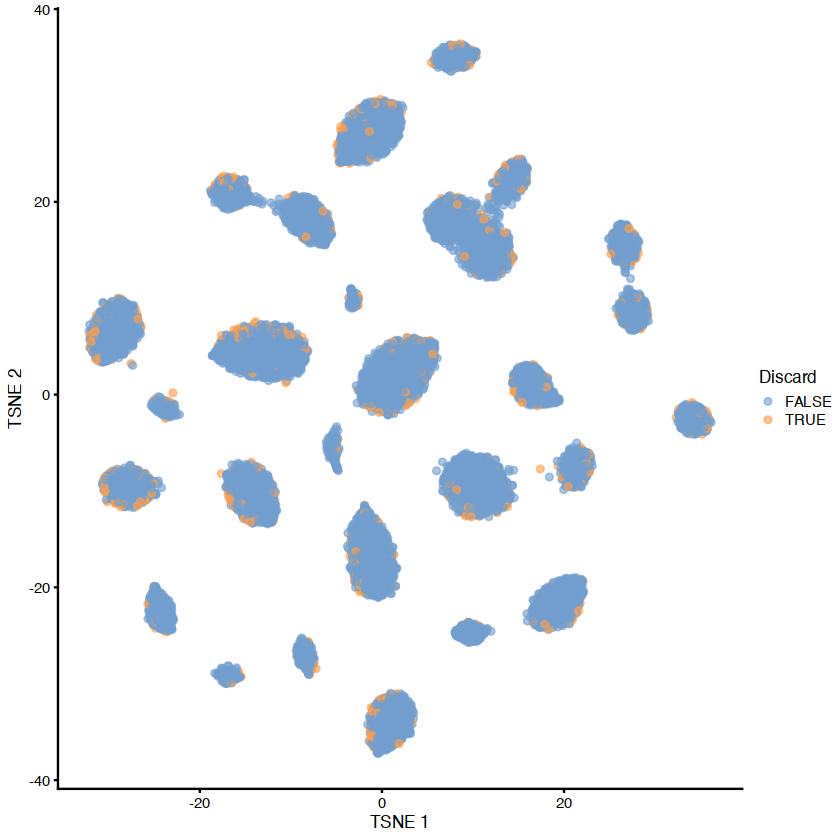

Saving 7 x 7 in image


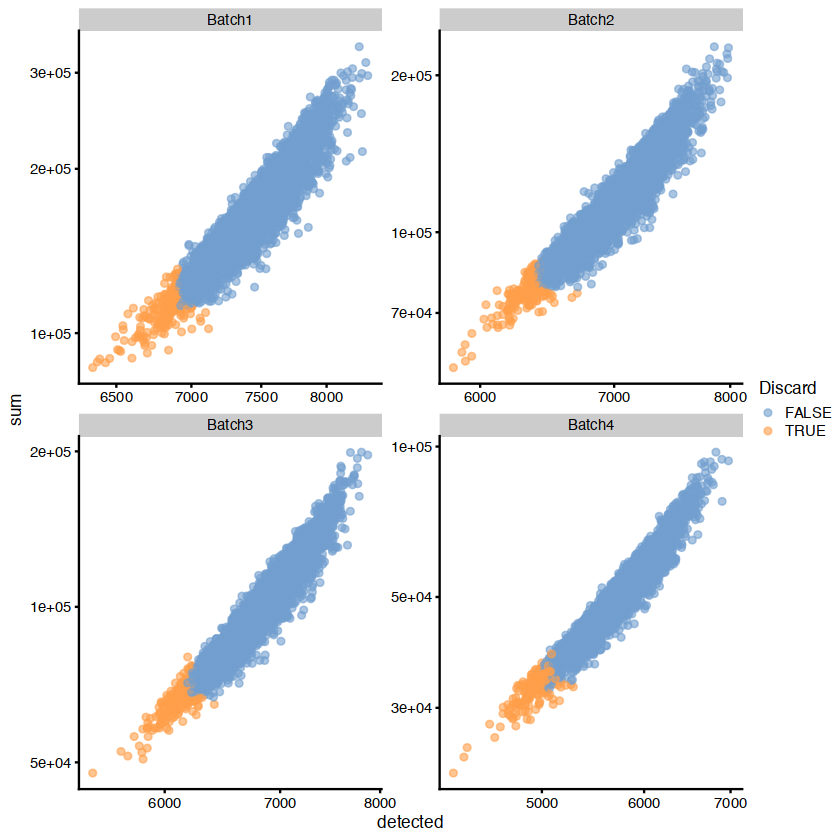

In [31]:
message("Saving QC plots..")
fs::dir_create(paste0(save_dir, "qc_plots/sim2"))

scater::plotTSNE(sim2, colour_by = "Batch")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-batch.png"))
scater::plotTSNE(sim2, colour_by = "Group")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-group.png"))
scater::plotTSNE(sim2, colour_by = "total")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-total.png"))
scater::plotTSNE(sim2_qc, colour_by = "Batch")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-batch-qc.png"))
scater::plotTSNE(sim2_qc, colour_by = "Group")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-group-qc.png"))
scater::plotTSNE(sim2_qc, colour_by = "total")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-total-qc.png"))
scater::plotTSNE(sim2, colour_by = "Discard")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-filt.png"))
scater::plotColData(sim2, "sum", "detected", colour_by = "Discard",
                    other_fields = "Batch") +
    ggplot2::scale_x_log10() +
    ggplot2::scale_y_log10() +
    ggplot2::facet_wrap(~ Batch, scales = "free")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/filtering.png"))

In [32]:
# Remove intermediate matrices to reduce file size
assays(sim2) <- assays(sim2)[assayNames(sim2) == "counts"]
assays(sim2_qc) <- assays(sim2_qc)[assayNames(sim2_qc) == "counts"]
saveRDS(sim2, paste0(data_dir, "sim2.Rds"))
saveRDS(sim2_qc, paste0(data_dir, "sim2_qc.Rds"))

In [2]:
sim2 = readRDS(paste0(data_dir, "sim2.Rds"))
sim2_qc = readRDS(paste0(data_dir, "sim2_qc.Rds"))

In [33]:
library(reticulate)
use_condaenv("concord", required = TRUE)

In [34]:
message("Converting to AnnData...")
anndata <- reticulate::import("anndata")
sim2_adata <- anndata$AnnData(
    X = t(counts(sim2)),
    obs = data.frame(colData(sim2)),
    var = data.frame(rowData(sim2))
)
sim2_qc_adata <- anndata$AnnData(
    X = t(counts(sim2_qc)),
    obs = data.frame(colData(sim2_qc)),
    var = data.frame(rowData(sim2_qc))
)

Converting to AnnData...



In [35]:
message("Saving simulation...")
sim2_adata$write(filename = paste0(data_dir, "sim2.h5ad"))
sim2_qc_adata$write(filename = paste0(data_dir, "sim2_qc.h5ad"))

Saving simulation...



In [36]:
dim(sim2_qc)

[1] 10000 19318

In [37]:
ds_genes = sample(rownames(sim2_qc), 1000)
ds_cells = sample(colnames(sim2_qc), 1000)
sim2_qc_ds = sim2_qc[ds_genes, ds_cells]

Saving 7 x 7 in image


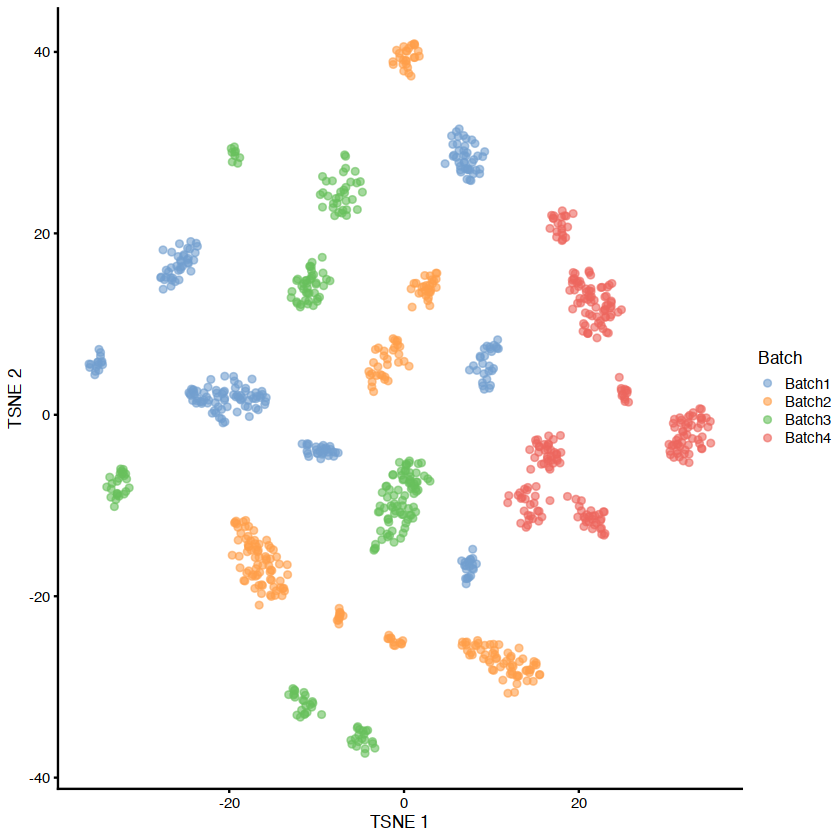

Saving 7 x 7 in image


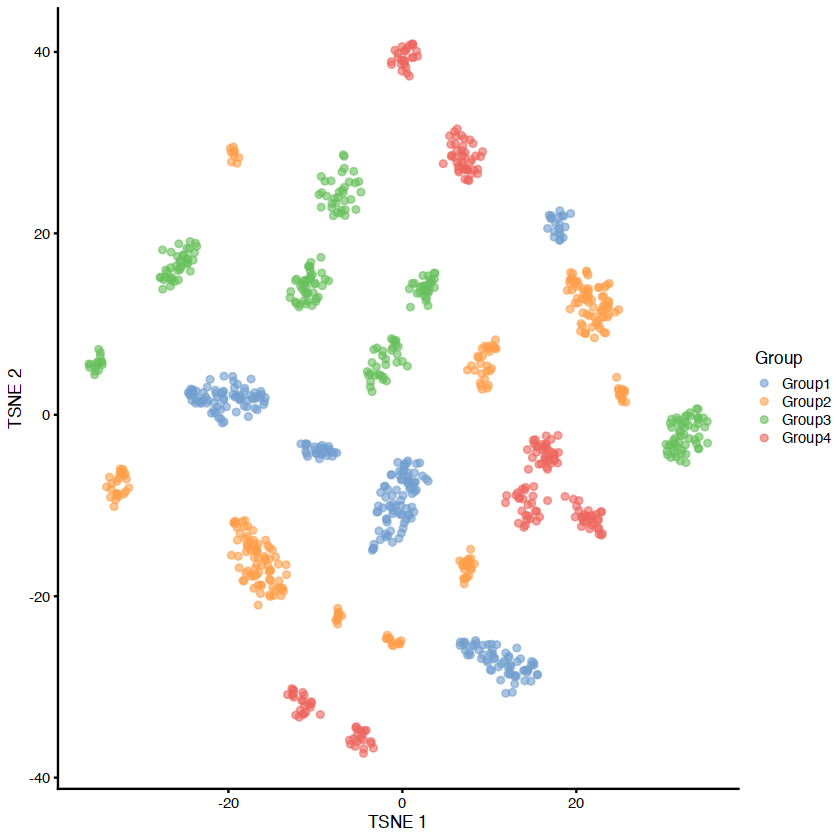

In [38]:
scater::plotTSNE(sim2_qc_ds, colour_by = "Batch")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-batch-qc-ds.png"))
scater::plotTSNE(sim2_qc_ds, colour_by = "Group")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim2/tsne-group-qc-ds.png"))

In [39]:
sim2_qc_ds <- scater::logNormCounts(sim2_qc_ds)

In [40]:
assay(sim2_qc_ds, "logcounts")

  [[ suppressing 32 column names 'Cell11171', 'Cell1234', 'Cell27639' ... ]]



1000 x 1000 sparse Matrix of class "dgCMatrix"
                                                                           
Gene3774 1.8473488 .         1.284271 .        0.9193171 .        .        
Gene8024 4.9687576 3.7508456 4.667042 3.160464 4.1282576 4.170286 4.9513884
Gene4062 2.1585021 1.2090252 2.753254 2.313416 1.8772179 .        2.3196073
Gene7779 2.4143084 3.0382563 3.940721 2.313416 3.1001987 3.050962 2.5825449
Gene5150 .         0.7276215 2.753254 .        .         .        .        
Gene8945 .         .         .        .        .         .        .        
Gene9469 3.8065216 3.8194779 2.753254 3.160464 3.3092050 3.421811 2.3196073
Gene5743 6.0623313 4.9621657 5.413869 5.822430 5.4955475 5.025906 6.4233969
Gene2647 .         1.2090252 .        .        .         .        .        
Gene5400 2.1585021 2.3031791 3.465861 2.798233 3.2428446 3.716561 2.3196073
Gene8268 2.6315156 2.3031791 1.952773 3.160464 2.8556985 .        2.3196073
Gene2606 1.4500924 0.7276215 .        .  

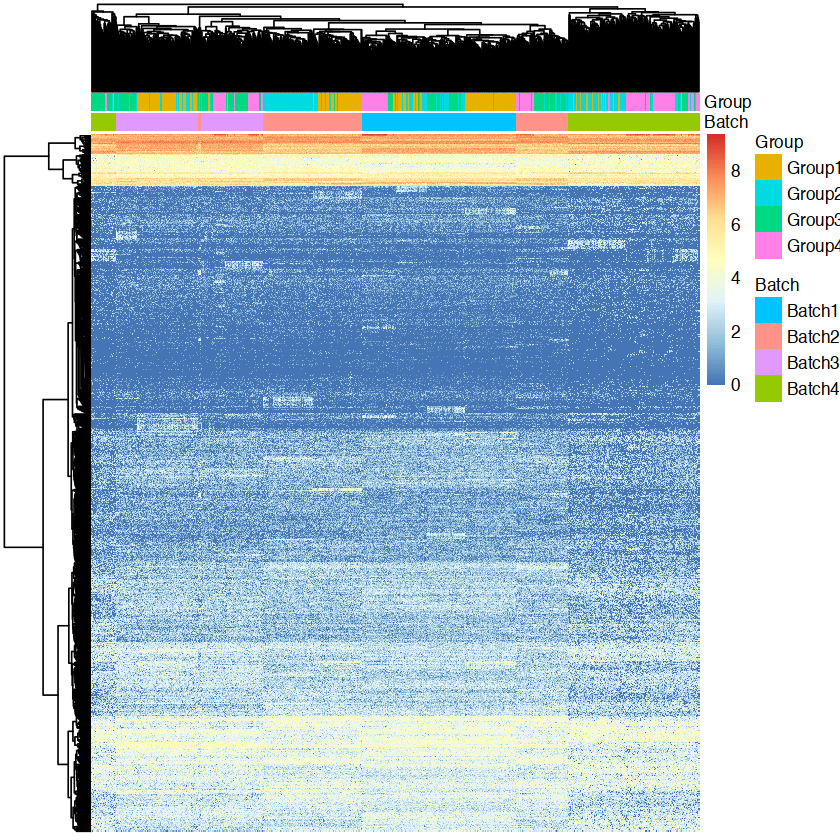

In [41]:
annotation_col <- as.data.frame(colData(sim2_qc_ds)[, c("Batch", "Group")])
rownames(annotation_col) <- colnames(assay(sim2_qc_ds, "logcounts"))

library(pheatmap)
pheatmap(as.matrix(assay(sim2_qc_ds, "logcounts")),
         annotation_col = annotation_col,  
         show_rownames = FALSE,            
         show_colnames = FALSE, 
         width = 10, height = 10)

In [29]:
sum(!complete.cases(annotation_col))

[1] 0